<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/time_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time HVAE

Hierarchical Variational Autoencoder (VAE) for multivariate time series.

VAE whose decoder output is the mean and log var of the input data and where the sampling process follows a Markov chain of the form zk → zk−1 → ... → z1 → x.

In [1]:
# Install the library

!pip install rapidae

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.path.abspath('') # get the current notebook directory
sys.path.append(os.path.join(notebook_dir, 'rapidae', 'src')) # add src folder to path to import modules
                                                        # '..', 'src' if you are in the 'examples' folder

In [2]:
from rapidae.data import load_dataset
from rapidae.models import TimeHVAE
from rapidae.pipelines import TrainingPipeline
from rapidae.evaluate import plot_latent_space, plot_reconstructions

2024-04-29 17:13:41.637861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 17:13:42.779337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In [38]:
# Load senoid dataset
data = load_dataset("SineWave")

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

print("Data shape:", x_train.shape)

2024-04-29 17:28:30 [INFO]: Downloading sine_wave.npy...


2024-04-29 17:28:30 [INFO]: Deleting data...


Data shape: (7017, 73, 1)


### Model

In [39]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

model = TimeHVAE((timesteps, num_features))

2024-04-29 17:28:33 [INFO]: Trying to set encoder and decoder from child class...
2024-04-29 17:28:33 [INFO]: Encoder set from time_hvae
2024-04-29 17:28:33 [INFO]: Decoder set from time_hvae


### Training

In [44]:
epochs = 300
batch_size = 128

pipe = TrainingPipeline(name='TimeHVAE_Senoid', 
                        learning_rate=0.0001,
                        model=model, 
                        num_epochs=epochs, 
                        batch_size=batch_size,
                        run_eagerly=True,)

trained_model = pipe(x=x_train)

2024-04-29 17:36:27 [INFO]: +++ TimeHVAE_Senoid +++
2024-04-29 17:36:27 [INFO]: Creating folder in ./output_dir/TimeHVAE_Senoid_2024-04-29_17-36
2024-04-29 17:36:27 [INFO]: 
TRAINING STARTED
	Backend: tensorflow
	Eager mode: True
	Validation data available: False
	Callbacks set: ['EarlyStopping', 'ModelCheckpoint'] 



Epoch 1/300
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
shape of kl:  (128, 73)
shape of recon_losses:  (128, 73)
sh

KeyboardInterrupt: 

### Evaluation

In [8]:
outputs = trained_model.predict(x_train)

220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step


2024-04-23 18:56:46 [INFO]: Latent space > 2. Performing dimensionality reduction using t-SNE...


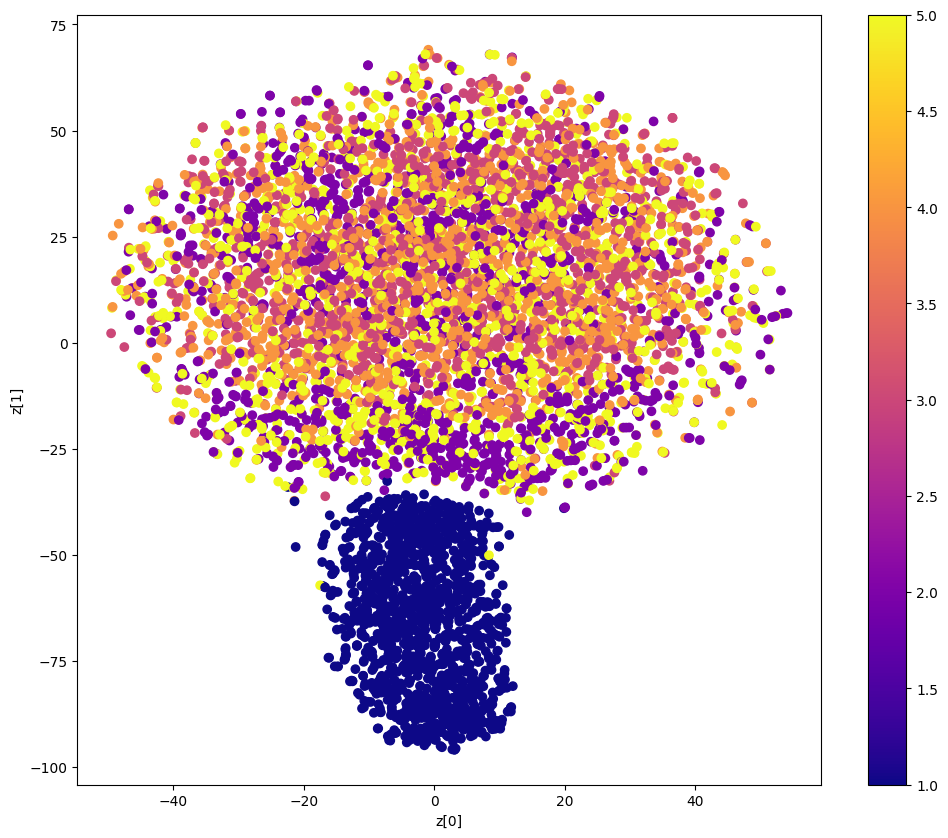

In [9]:
plot_latent_space(outputs['z'], y_train)

In [5]:
model.load_weights(os.path.join("./output_dir/TimeHVAE_Senoid_2024-04-24_16-48", "model.weights.h5"))

In [6]:
reconstructions = model.reconstruct(x_train)

2024-04-25 07:30:34.675516: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409792800 exceeds 10% of free system memory.
2024-04-25 07:30:34.834574: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409792800 exceeds 10% of free system memory.
2024-04-25 07:30:39.514530: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409792800 exceeds 10% of free system memory.
2024-04-25 07:30:39.667247: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409792800 exceeds 10% of free system memory.
2024-04-25 07:30:39.901517: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409792800 exceeds 10% of free system memory.


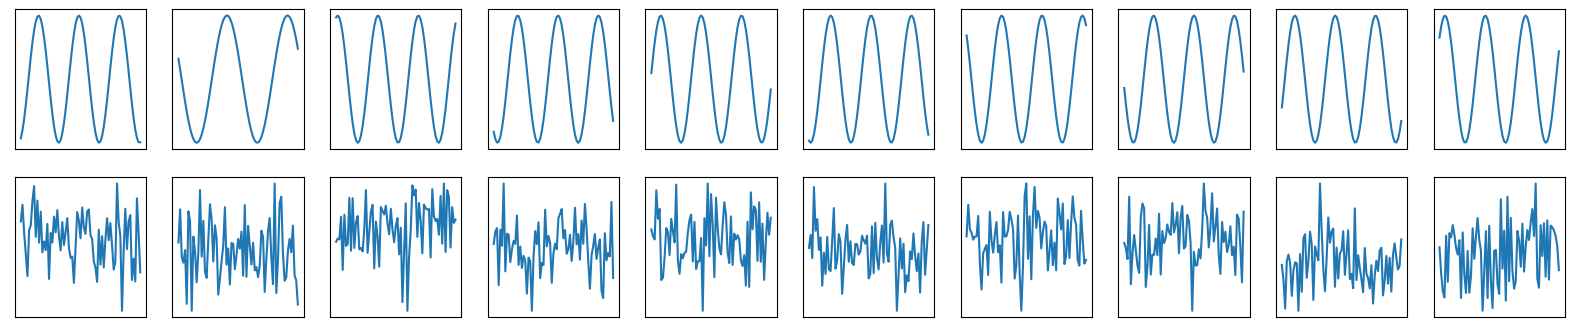

In [7]:
#reconstructions = trained_model.reconstruct(x_train)
plot_reconstructions(x_train, reconstructions.numpy(), type="ts")

shapes

In [5]:
import numpy as np

In [20]:
from rapidae.models.base import BaseEncoder
from keras.layers import Masking, LSTM, Bidirectional, Dense


class Encoder(BaseEncoder):
    def __init__(self, input_dim, latent_dim, nz=1, embed_dim=100, **kwargs):
        BaseEncoder.__init__(self, input_dim, latent_dim)
        self.nz = nz
        self.embed_dim = embed_dim
        self.hidden_dim = 2 * embed_dim

        # BOTTOM LATENT LAYER
        self.masking_value = (
            kwargs["masking_value"] if "masking_value" in kwargs else -99.0
        )
        self.mask = Masking(mask_value=self.masking_value)

        self.rnn1 = Bidirectional(
            LSTM(self.hidden_dim, return_sequences=True)
        )  # this returns output, hidden_state_f, cell_state_f, hidden_state_b, cell_state_b
        self.rnn2 = Bidirectional(LSTM(self.embed_dim, return_sequences=True))

        self.fc_mu = Dense(self.latent_dim)
        self.fc_var = Dense(self.latent_dim)

    def call(self, x, **kwargs):
        lvl = kwargs["lvl"] if "lvl" in kwargs else 0

        # bottom latent layer
        if lvl == 0:
            x = self.mask(x)
            print("shape after masking", x.shape)
            # (batch_size, seq_len, hidden_dim*2)
            x = self.rnn1(x)
            print("shape after rnn1", x.shape)
            # (batch_size, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim)
            # (batch_size, seq_len, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim), (batch_size, embed_dim) if return_sequences=True
            x = self.rnn2(x)
            print("shape after rnn2", x.shape)
            # (batch_size, latent_dim)
            mu = self.fc_mu(x)
            # (batch_size, latent_dim)
            log_var = self.fc_var(x)
        # deeper latent layers
        else:
            lvl -= 1

        return mu, log_var

In [21]:
seq_len, feat_dim = 71, 1
sample_data = np.ones((64, seq_len, feat_dim))
encoder = Encoder((seq_len, feat_dim), 2)

In [22]:
mu, log_var = encoder(sample_data)
print(mu.shape, log_var.shape)

shape after masking (64, 71, 1)
shape after rnn1 (64, 71, 400)
shape after rnn2 (64, 71, 200)
shape after masking (64, 71, 1)
shape after rnn1 (64, 71, 400)
shape after rnn2 (64, 71, 200)
(64, 71, 2) (64, 71, 2)


In [35]:
from rapidae.models.base import BaseDecoder
from keras.layers import Dense, RepeatVector, LSTM, Bidirectional
from keras.ops import reshape


class Decoder(BaseDecoder):
    def __init__(self, input_dim, latent_dim, embed_dim=32):
        BaseDecoder.__init__(self, input_dim, latent_dim)
        self.seq_len = input_dim[0]
        self.embed_dim = embed_dim
        self.hidden_dim = 2 * embed_dim
        self.feat_dim = input_dim[1]

        # BOTTOM LATENT LAYER
        self.fc = Dense(embed_dim)
        #self.repeat = RepeatVector(self.seq_len)
        self.rnn1 = Bidirectional(LSTM(self.embed_dim, return_sequences=True))
        self.rnn2 = LSTM(self.hidden_dim, return_sequences=True)
        self.output_layer_mean = Dense(self.feat_dim)
        self.output_layer_log_var = Dense(self.feat_dim)

    def call(self, x, **kwargs):
        lvl = kwargs["lvl"] if "lvl" in kwargs else 0

        # bottom latent layer
        if lvl == 0:
            # (batch_size, embed_dim)
            x = self.fc(x)
            # (batch_size, seq_len, embed_dim)
            #x = self.repeat(x)
            # (batch_size, seq_len, embed_dim)
            x = self.rnn1(x)
            # (batch_size, seq_len, embed_dim)
            x = self.rnn2(x)
            # (batch_size * seq_len, embed_dim)
            #x = reshape(x, (-1, self.hidden_dim))
            # (batch_size * seq_len, feat_dim)
            x_mean = self.output_layer_mean(x)
            # (batch_size, seq_len, feat_dim)
            #x_mean = reshape(x_mean, (-1, self.seq_len, self.feat_dim))
            # (batch_size * seq_len, feat_dim)
            x_log_var = self.output_layer_log_var(x)
            # (batch_size, seq_len, feat_dim)
            #x_log_var = reshape(x_log_var, (-1, self.seq_len, self.feat_dim))
        # deeper latent layers
        else:
            lvl -= 1

        return x_mean, x_log_var

In [36]:
seq_len, feat_dim = 71, 1
sample_data = np.ones((64, seq_len, feat_dim))
decoder = Decoder((seq_len, feat_dim), 2)

In [37]:
mu, log_var = decoder(sample_data)
print(mu.shape, log_var.shape)

(64, 71, 1) (64, 71, 1)
